In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

In [2]:
n_t = 200
n_c, n_s = 3,10
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.eye(n_s)
A[:3, :3] = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A[:3, :3], J[:3, i])


SC = np.eye(n_s)
SC[:3, :3] = np.array([[1,1,1], [1,1,0],[1,0,1]])



(-5, 200)

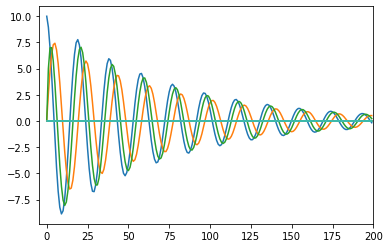

In [3]:
plt.plot(J.T)

plt.xlim(-5, n_t)

In [4]:
m_p = 1
M = np.dot(G, J[:, m_p:])


In [5]:
cll = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-2, 1], verbose=1, old_version=False)
cll.solver(G, M, SC, nbr_iter=10, model_p=2, A=None, S_tol=1e-3, normalize=False)
R = cll.coef_
cll.la

Iteration 0: nbr of active sources 10
Iteration 1: nbr of active sources 5
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:157: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039799995861233645, tolerance: 0.0036780925833123
  check_random_state(self.random_state), random, self.verbose)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.22674878318684, tolerance: 0.3234191099095388
  positive)


[0.01, 1]

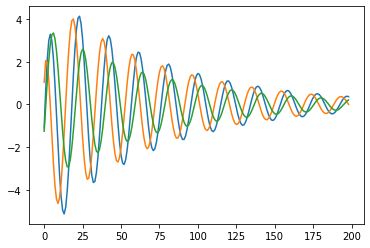

In [79]:
plt.plot(R[:, m_p:].T);

In [80]:
## grid search

In [6]:
gridsearch = {
    'l21_values':np.logspace(-5.0, 2.0, num=10),
    'la_values':np.logspace(-5, 0.0, num=10),
    'la_ratio_values':[1],
    'normalize':[0],
    'model_p':[1],
    'old_version':[False]
    }


In [7]:
cl = ciSDR.eiSDR_cv(**gridsearch, verbose=True, max_run=500)

In [8]:
df = cl.get_opt(G, M, SC)

Total number of combination 100
Successfully created the directory /tmp/tmp_8b89f39d-a40b-4d58-9543-20931adf151c 


  0%|          | 0/100 [00:00<?, ?it/s]/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWar

/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.83922323742109, tolerance: 0.08310594443690958
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.42984268495811, tolerance: 0.10126845227982231
  positive)
/Users/EEAL

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.327120757670013, tolerance: 0.05139418528418678
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.327120757670013, tolerance: 0.05139418528418678
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.92434945794313, tolerance: 1.1825896166466028
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEAL

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7080715754636433, tolerance: 0.27704724131827013
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py

 30%|███       | 30/100 [00:04<00:56,  1.24it/s]/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.42984268495811, tolerance: 0.10126845227982231
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cyt

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7080715754636433, tolerance: 0.27704724131827013
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7080715754636433, tolerance: 0.27704724131827013
  positive)
/Users/EE

 45%|████▌     | 45/100 [00:06<00:25,  2.16it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.221487041753493, tolerance: 0.8003505853489434
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.603198974549754, toleran

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7080715754636433, tolerance: 0.27704724131827013
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.817621463496693e-31, tolerance: 1.6222485320201675e-33
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Us

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.539222843706717, tolerance: 0.03606710929800901
  positive)
 59%|█████▉    | 59/100 [00:08<00:12,  3.34it/s]/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.83922323742109, toler

/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.760940362992648, tolerance: 0.16036332613035276
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:216: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, yt)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_m

Successfully deleted the directory /tmp/tmp_8b89f39d-a40b-4d58-9543-20931adf151c


In [9]:
df.Obj.min()

0.017799375809628003

In [10]:
df

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
19,0.014494,10,209.958286,15.448719,30.971258,0.00001,0.00001,1.0,1,0,0.000015,0.017799


In [11]:
clf = ciSDR.linear_model.iSDR(l21_ratio=df.ls_reg.values[0], la=[df.la_reg_a.values[0], df.la_reg_r.values[0]], verbose=1)
clf.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3, normalize=0)
R = clf.coef_

Iteration 0: nbr of active sources 10
Iteration 1: nbr of active sources 10
Stopped at iteration 1 : Change in active set tol 10.0000 > 10.0000  


In [12]:
clf.active_set[-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
df.ls_reg.values[0]

1e-05

(0, 200)

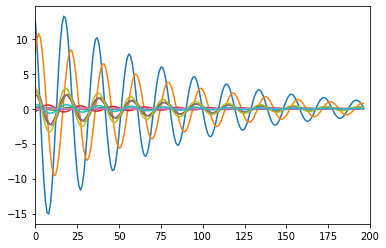

In [14]:
plt.plot(R[:, m_p+1:].T)
plt.xlim(0, n_t)

(0, 200)

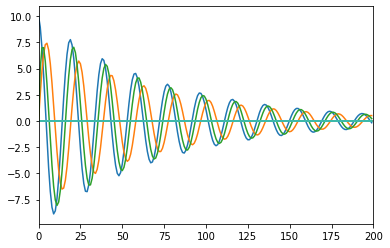

In [15]:
plt.plot(J[:, :].T);
plt.xlim(0,n_t)

In [16]:
df[df.Obj == df.Obj.min()]

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
19,0.014494,10,209.958286,15.448719,30.971258,0.00001,0.00001,1.0,1,0,0.000015,0.017799


In [17]:
cl.results

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
0,0.011634,6,9.202535e+01,6.889947,6.687375,0.002154,0.000129,1.0,1,0,0.003233,0.310030
1,9.241235,1,4.243344e-15,0.929840,0.864603,100.000000,0.077426,1.0,1,0,150.056619,9.313229
2,0.207971,5,6.829704e+01,4.679337,4.379674,0.012915,0.021544,1.0,1,0,0.019381,1.632419
3,0.203099,5,6.419601e+01,4.676662,4.374681,0.464159,0.000464,1.0,1,0,0.696501,44.917862
4,1.755623,1,2.117973e+01,0.928884,0.862826,16.681005,1.000000,1.0,1,0,25.030953,532.833226
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.176821,8,1.848116e+02,8.307118,7.206525,0.000060,0.000036,1.0,1,0,0.000090,0.193745
96,0.207971,5,6.829704e+01,4.679337,4.379674,0.012915,0.000129,1.0,1,0,0.019381,1.532210
97,0.229667,5,4.415085e+01,4.676775,4.374885,2.782559,0.000010,1.0,1,0,4.175415,184.577797
98,0.011634,6,9.202535e+01,6.889947,6.687375,0.002154,0.005995,1.0,1,0,0.003233,0.350444


In [18]:
clf.Acoef_

array([[ 0.851562  , -0.45189956,  6.89968685,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.70427205,  0.62249208,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.17536602,  0.        ,  2.28092908,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.00838253,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -4.22268883,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.68924735,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -7.57105006,  0.        

In [19]:
clf.get_phi()

In [20]:
clf.eigs

,real,imag
eig,,
eig_0,0.454100,0.457099
eig_1,0.454100,-0.457099
eig_2,2.846784,0.000000
eig_3,2.008383,0.000000
eig_4,-4.222689,0.000000
eig_5,-0.689247,0.000000
eig_6,-7.571050,0.000000
eig_7,0.498670,0.000000
eig_8,-0.419135,0.000000


In [21]:
np.linalg.eigvals(A)

array([0.5  +0.j       , 0.935+0.3142849j, 0.935-0.3142849j,
       1.   +0.j       , 1.   +0.j       , 1.   +0.j       ,
       1.   +0.j       , 1.   +0.j       , 1.   +0.j       ,
       1.   +0.j       ])